#  房屋出售价格预测(回归)

## 1. 利用pandas库导入数据 

了解初始数据信息，包括训练数据和测试数据

In [1]:
import pandas as pd

train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')
# 训练数据的X部分
train_df = train_data.iloc[:,0:-1]
# 训练数据的Y部分
Y = train_data['SalePrice']

test_df = test_data
train_df.info()
print('----------------------------------------------------------')
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [2]:
# 训练数据
train_df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal


In [3]:
# 测试数据
test_data.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal


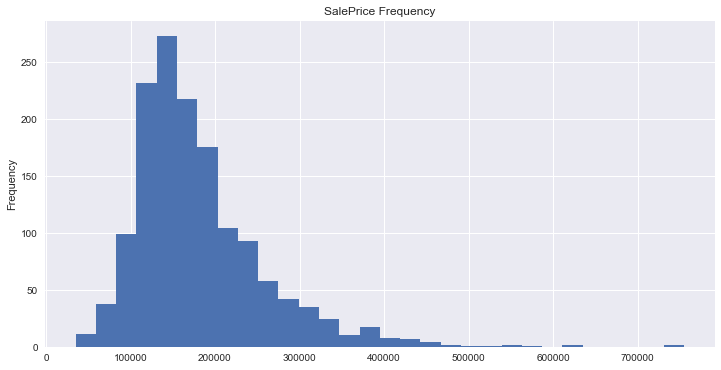

In [4]:
# 房屋出售价格的直方图
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
plt.figure(figsize=(12,6))
Y.plot(kind='hist', bins=30, title="SalePrice Frequency")


##  2. 特征工程

#### 2.1 清除无用特征 

In [5]:
# 从数据集中去除Id这个无用特征
train_df = train_df.drop(['Id'],axis=1)
test_data = test_data.drop(['Id'],axis=1)

In [6]:
NaNs = train_df.isnull().sum()
NaNs = NaNs[NaNs>0]
print(NaNs)

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64


In [7]:
# 删除有较多缺失值的特征
# 从训练数据可以发现，Alley、PoolQC、Fence、MiscFeature均有超过2/3的缺失值，直接删除这些特征
train_df = train_df.drop(['Alley','PoolQC','Fence','MiscFeature'],axis=1)
test_data = test_data.drop(['Alley','PoolQC','Fence','MiscFeature'],axis=1)

#### 2.2 特征分类 

In [8]:
# 由上面数据集的信息可以发现，训练集中int64类属性有34个，float64属性有3个，object类属性有39个
# 测试集中int64属性有25个，float64属性有11个，object类属性有39个。
# 从数据集可以发现，所有特征中有两个二元特征，street和CentralAir，对其取值转化为0/1
import numpy as np

train_df['Street'] = train_df['Street'].apply(lambda x: 1 if x=='Pave' else 0)
test_data['Street'] = test_data['Street'].apply(lambda x: 1 if x=='Pave' else 0)

train_df['CentralAir'] = train_df['CentralAir'].apply(lambda x: 1 if x=='Y' else 0)
test_data['CentralAir'] = test_data['CentralAir'].apply(lambda x: 1 if x=='Y' else 0)
Bi_features = ['Street','CentralAir']
for feature in Bi_features:
    print(train_df[feature].value_counts())


1    1454
0       6
Name: Street, dtype: int64
1    1365
0      95
Name: CentralAir, dtype: int64


In [9]:
train_df['MSSubClass'] = train_df['MSSubClass'].astype(str)
test_data['MSSubClass'] = test_data['MSSubClass'].astype(str)

# 对于数据集中的特征，分为三大类，二元属性（0/1）、数字特征和类别属性
Cate_features = train_df.select_dtypes(include=[object]).columns.values
Num_features = train_df.select_dtypes(exclude=[object]).columns.values
Num_features = [Num_features for Num_features in Num_features if Num_features not in Bi_features]
print('二元特征：',Bi_features,len(Bi_features))
print('类别特征：',Cate_features,len(Cate_features))
print('数字特征：',Num_features,len(Num_features))

二元特征： ['Street', 'CentralAir'] 2
类别特征： ['MSSubClass' 'MSZoning' 'LotShape' 'LandContour' 'Utilities' 'LotConfig'
 'LandSlope' 'Neighborhood' 'Condition1' 'Condition2' 'BldgType'
 'HouseStyle' 'RoofStyle' 'RoofMatl' 'Exterior1st' 'Exterior2nd'
 'MasVnrType' 'ExterQual' 'ExterCond' 'Foundation' 'BsmtQual' 'BsmtCond'
 'BsmtExposure' 'BsmtFinType1' 'BsmtFinType2' 'Heating' 'HeatingQC'
 'Electrical' 'KitchenQual' 'Functional' 'FireplaceQu' 'GarageType'
 'GarageFinish' 'GarageQual' 'GarageCond' 'PavedDrive' 'SaleType'
 'SaleCondition'] 38
数字特征： ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',

#### 2.3 类别特征缺失值处理 

In [10]:
# 对于有的类别特征的缺失值，可以用该特征最频繁出现的值进行替代
NaN_C = ['MasVnrType', 'Electrical', 'MSZoning', 'Utilities']
for fea in NaN_C:
    train_df[fea].fillna(train_df[fea].value_counts().idxmax(),inplace=True)
    test_data[fea].fillna(test_data[fea].value_counts().idxmax(),inplace=True)

# 对于某些类别特征的缺失值，构造一个新的值代替缺失值
NaN_c = Cate_features[np.in1d(Cate_features,NaN_C,invert=True)]
for Fea in NaN_c:
    train_df[Fea].fillna('NA',inplace=True)
    test_data[Fea].fillna('NA',inplace=True)

#### 2.4 数值特征缺失值处理 

In [11]:
# 训练数据
NaN_N = train_df[Num_features].isnull().sum()
NaN_n = NaN_N[NaN_N > 0].index.values
print(NaN_n)
# 测试集
NaN_N_test = test_data[Num_features].isnull().sum()
NaN_n_test = NaN_N_test[NaN_N_test > 0].index.values
print(NaN_n_test)

['LotFrontage' 'MasVnrArea' 'GarageYrBlt']
['LotFrontage' 'MasVnrArea' 'BsmtFinSF1' 'BsmtFinSF2' 'BsmtUnfSF'
 'TotalBsmtSF' 'BsmtFullBath' 'BsmtHalfBath' 'GarageYrBlt' 'GarageCars'
 'GarageArea']


In [12]:
# 训练数据集中的数值特征的缺失值用平均数代替
for Nfea in NaN_n:
    train_df[Nfea].fillna(train_df[Nfea].median(),inplace=True)
for Nfea1 in NaN_n_test:
    test_data[Nfea1].fillna(test_data[Nfea1].median(),inplace=True)


In [13]:
# 检查训练集中是否还有缺失值
Nyn = train_df.isnull().sum()
print(Nyn[Nyn > 0])
Nyn_test = test_data.isnull().sum()
print(Nyn_test[Nyn_test > 0])

Series([], dtype: int64)
Series([], dtype: int64)


#### 2.5 类别特征分析 

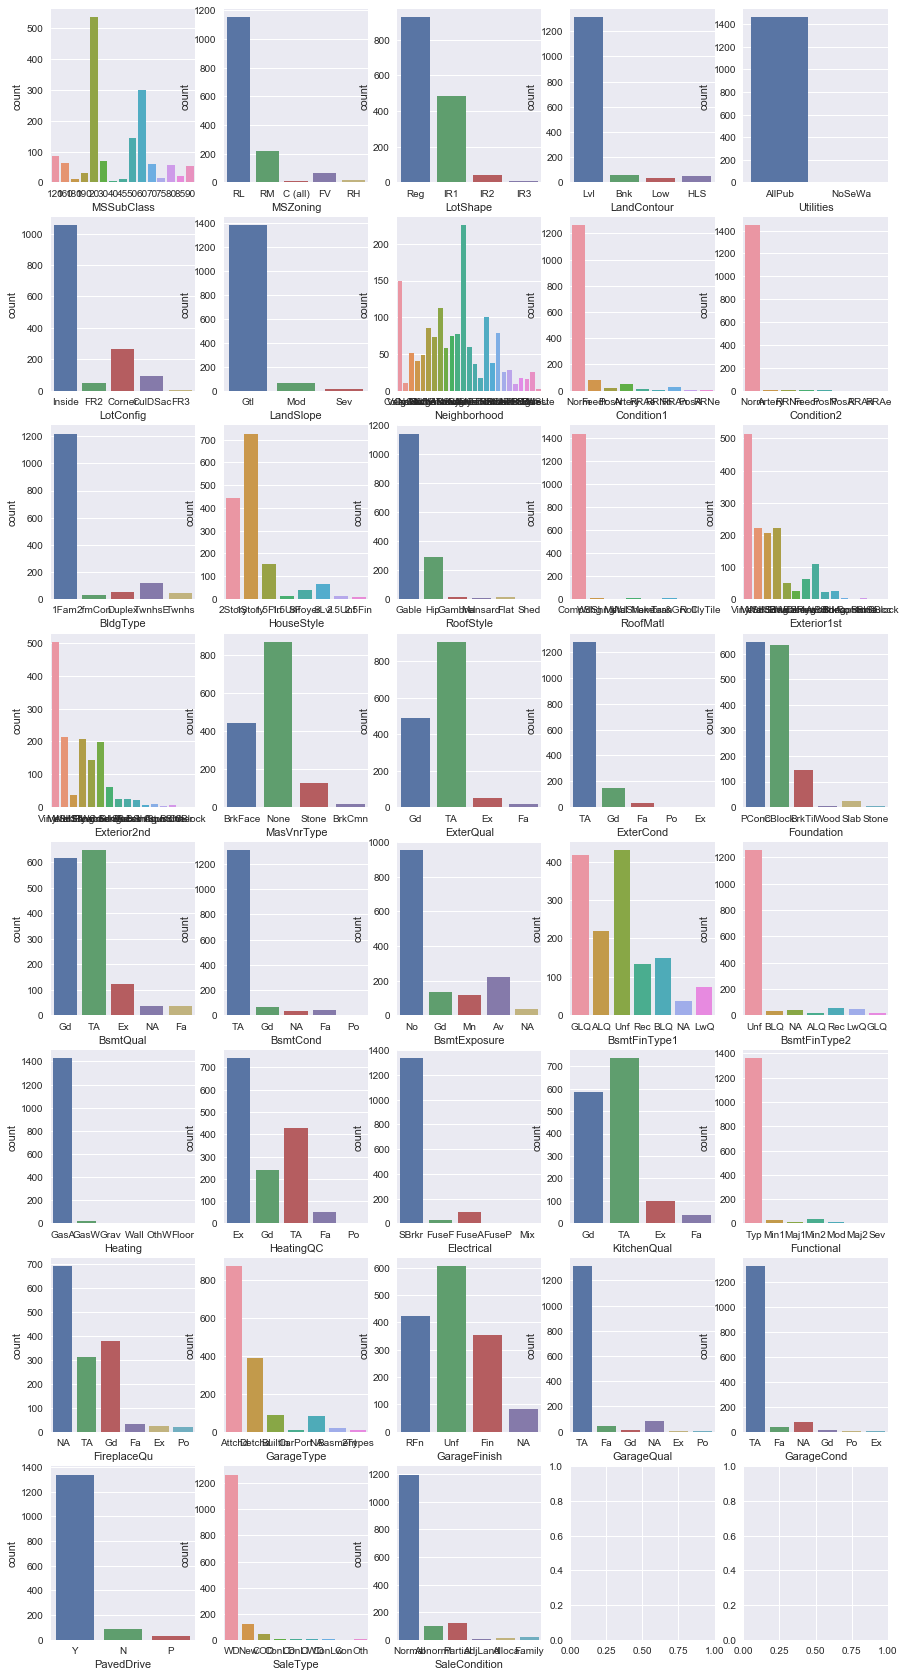

In [14]:
fig,axes = plt.subplots(8,5,figsize=(15,30))
for i,feature in enumerate(Cate_features):
    sns.countplot(x=feature,data=train_df,ax=axes[i//5][i%5])

In [15]:
# 对于上面的类别特征，删除一些类别取值极度不平衡的特征
to_remove = ['Utilities','Condition2','RoofMatl','Heating']
train_df.drop(to_remove,axis=1,inplace=True)
test_data.drop(to_remove,axis=1,inplace=True)
Cate_features = Cate_features[~np.in1d(Cate_features,to_remove)]

#### 2.6 二元特征分析 

In [16]:
# 直接删除不平衡特征
train_df.drop(['Street'],axis=1,inplace=True)
test_data.drop(['Street'],axis=1,inplace=True)
Bi_features = ['CentralAir']

#### 2.7 数值特征分析 

D:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


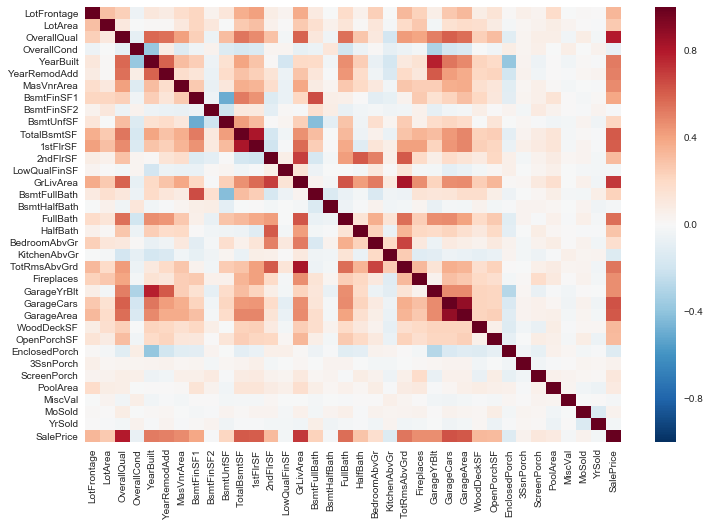

In [17]:
# 分析数值特征与出售价格的热点图
train_Num = train_df[Num_features]
train_Num['SalePrice'] = Y
# heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(train_Num.corr())

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000DB06048>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000000000FC7B5F8>]], dtype=object)

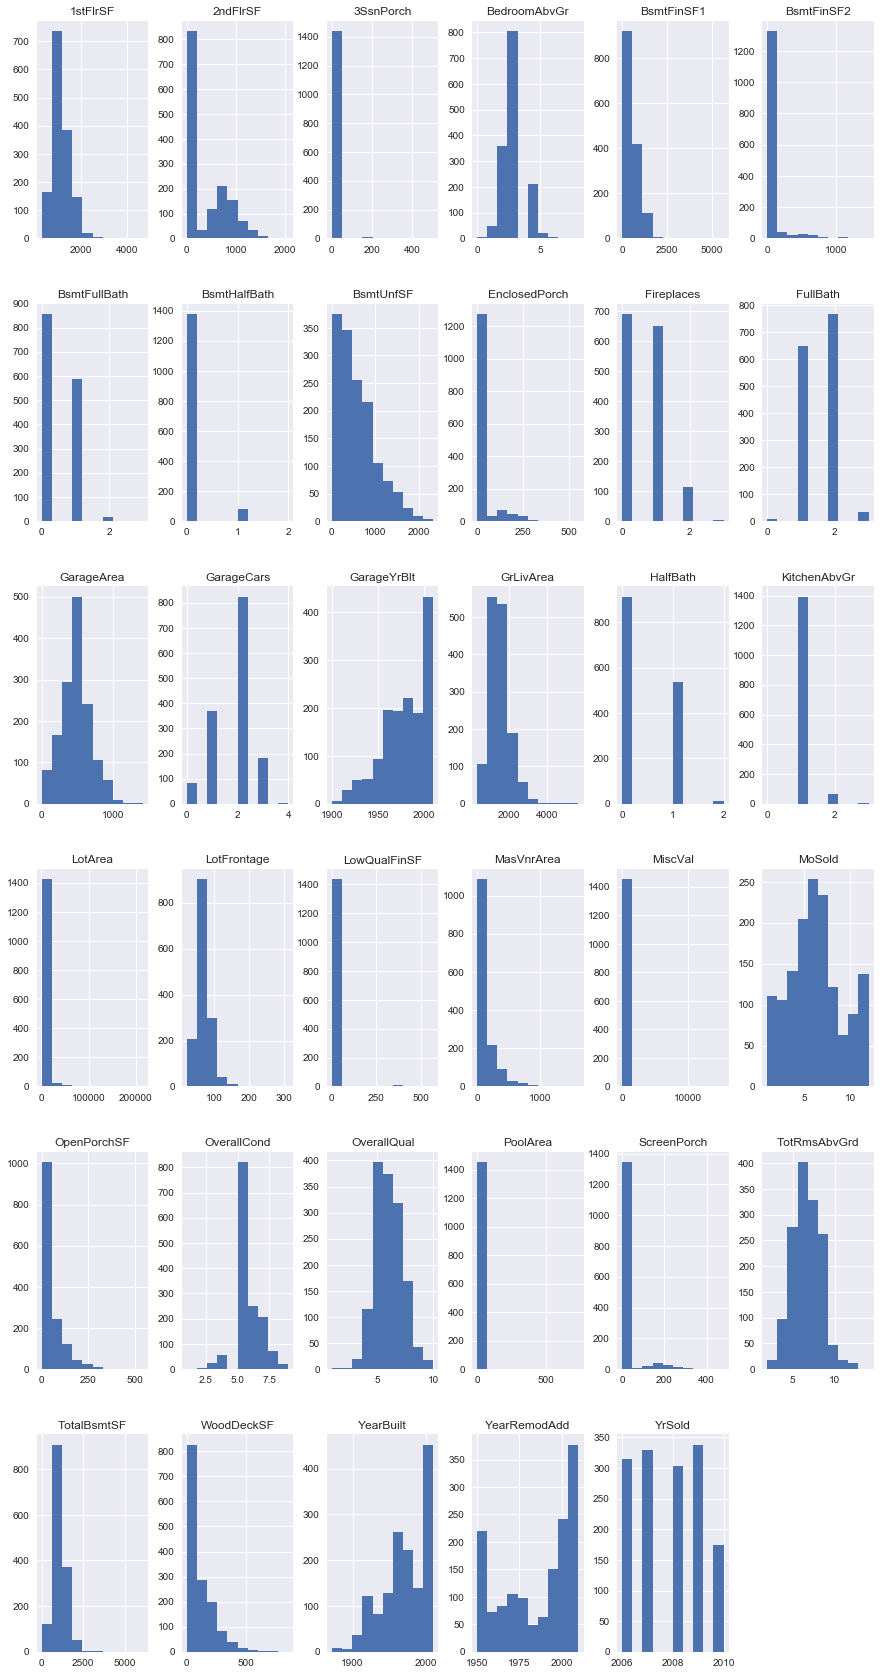

In [18]:
train_df[Num_features].hist(figsize=(15,30))

In [19]:
# 去除一些与房价相关性很低的数值特征
remove_1 = ['3SsnPorch', 'LowQualFinSF', 'MiscVal', 'PoolArea']
train_df.drop(remove_1,axis=1,inplace=True)
test_data.drop(remove_1,axis=1,inplace=True)
Num_features = [Num_features for Num_features in Num_features if Num_features not in remove_1]


#### 2.8 类别特征编码 

In [20]:
train_df = pd.get_dummies(data=train_df,columns=Cate_features)
train_df.info()

test_data = pd.get_dummies(data=test_data,columns=Cate_features)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 268 entries, LotFrontage to SaleCondition_Partial
dtypes: float64(3), int64(29), uint8(236)
memory usage: 701.6 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Columns: 268 entries, LotFrontage to SaleCondition_Partial
dtypes: float64(11), int64(21), uint8(236)
memory usage: 701.1 KB


In [21]:
from matplotlib import cm
from sklearn import preprocessing, manifold, linear_model, metrics, model_selection, ensemble


In [22]:
scaler = preprocessing.StandardScaler()
train_df[Num_features] = scaler.fit_transform(train_df[Num_features])
train_df.info()

test_data[Num_features] = scaler.fit_transform(test_data[Num_features])
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 268 entries, LotFrontage to SaleCondition_Partial
dtypes: float64(31), int64(1), uint8(236)
memory usage: 701.6 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Columns: 268 entries, LotFrontage to SaleCondition_Partial
dtypes: float64(31), int64(1), uint8(236)
memory usage: 701.1 KB


In [23]:
# 训练数据的维度，1460个样本，268个特征
print(train_df.shape,test_data.shape)


(1460, 268) (1459, 268)


#### 2.9 数据可视化 

In [24]:
# 对价格做一个区间分类
def price_category(y):
    cl = pd.Series(index=y.index)
    cl[y < 100000] = 0
    cl[(y >= 100000) & (y < 150000)] = 1
    cl[(y >= 150000) & (y < 200000)] = 2
    cl[(y >= 200000) & (y < 250000)] = 3
    cl[(y >= 250000) & (y < 300000)] = 4
    cl[y >= 300000] = 5
    return cl
price_classes = price_category(Y)
labels = ['<100K', '100-150K', '150-200K', '200-250K', '250-300K', '>300K']

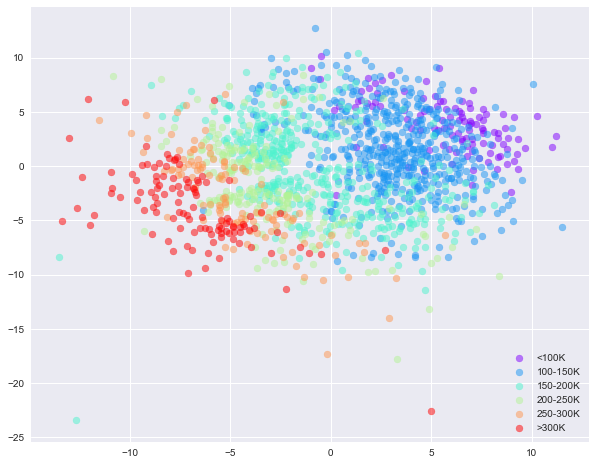

In [25]:
from sklearn.manifold import MDS
mds = MDS(random_state=123)
MDS_transformed = mds.fit_transform(train_df)

plt.figure(figsize=(10, 8))
colors = cm.rainbow(np.linspace(0, 1, 6))
for cls, color, label in zip(range(6), colors, labels):
    plt.scatter(MDS_transformed[price_classes.values==cls, 0], 
                MDS_transformed[price_classes.values==cls, 1], c=color, alpha=0.5, label=label)
plt.legend()

## 3. 回归分析 

#### 3.1 线性回归分析 

In [26]:
# 均方根对数误差
def rmsle_score(y, p):
    return -np.sqrt(np.sum((np.log(1+y) - np.log(1+p))**2)/y.shape[0])
rmsle = metrics.make_scorer(rmsle_score)

In [27]:
# 岭回归：交叉验证并计算均方根对数误差
param_grid = {
              'alpha': [0.5, 1, 2, 6, 10, 15, 20, 30, 40, 50, 75, 100, 125, 150],
             }

ridge = linear_model.Ridge()
ridge_gs = model_selection.GridSearchCV(ridge, param_grid, cv=3, scoring=rmsle)
ridge_gs.fit(train_df, Y)
print(ridge_gs.best_score_)
print(ridge_gs.best_params_)

-0.147963945185
{'alpha': 125}


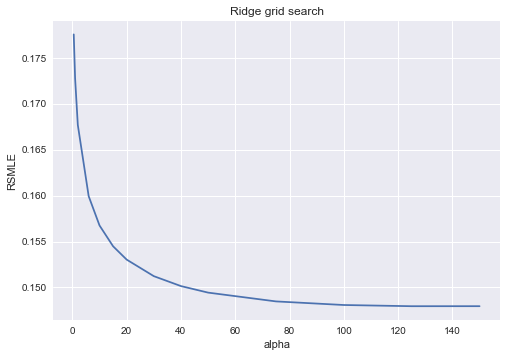

In [28]:
plt.plot([item['alpha'] for item in ridge_gs.cv_results_['params']], 
         [-item for item in ridge_gs.cv_results_['mean_test_score']])
plt.xlabel('alpha')
plt.ylabel('RSMLE')
plt.title('Ridge grid search')

In [29]:
# 套索回归
param_grid = {
              'alpha': [75, 100, 125, 150, 175,200,225,250,275,300],
             }
lasso = linear_model.Lasso()
lasso_gs = model_selection.GridSearchCV(lasso, param_grid, cv=3, scoring=rmsle)
lasso_gs.fit(train_df, Y)
print(lasso_gs.best_score_)
print(lasso_gs.best_params_)

-0.14817950616
{'alpha': 225}


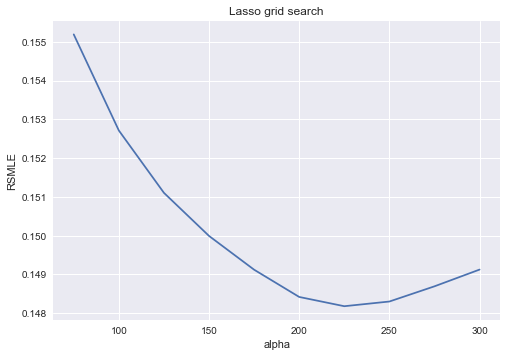

In [30]:
plt.plot([item['alpha'] for item in lasso_gs.cv_results_['params']], 
         [-item for item in lasso_gs.cv_results_['mean_test_score']])
plt.xlabel('alpha')
plt.ylabel('RSMLE')
plt.title('Lasso grid search')

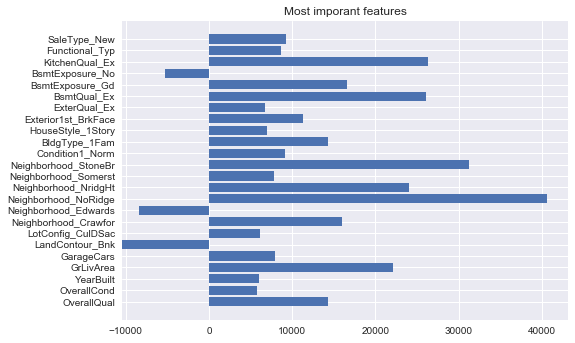

In [31]:
# 通过回归分析所得的系数，对于系数为零的无用特征可以舍去
coef = lasso_gs.best_estimator_.coef_
not_zero_indices = np.where(coef!=0)

# 利用回归分析的系数找出最重要的特征
large_indices = np.where(abs(coef) >= 5000)
plt.barh(range(len(large_indices[0])), coef[large_indices[0]])
plt.yticks(range(len(large_indices[0])), train_df.columns[large_indices[0]])
plt.title('Most imporant features')

In [32]:
# 舍去一些不重要的特征
X_selected = train_df.iloc[:,not_zero_indices[0]]

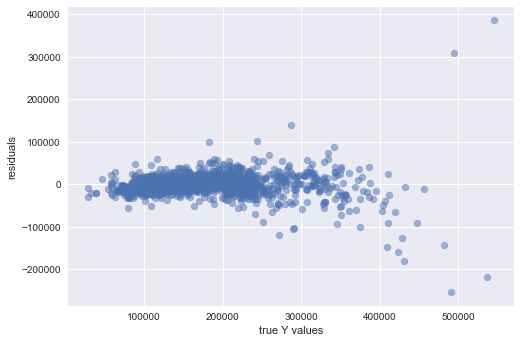

R2 score: 0.858741343261


In [33]:
# look at the residuals
predicts = lasso_gs.best_estimator_.predict(train_df)
plt.scatter(predicts, predicts-Y, alpha=0.5)
plt.xlabel('true Y values')
plt.ylabel('residuals')
plt.show()
print('R2 score: %s' % metrics.r2_score(predicts, Y))

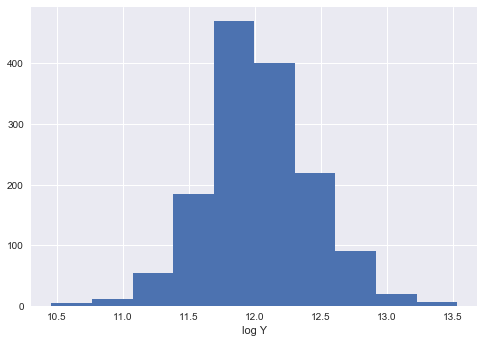

In [34]:
# 取对数
Y_log = np.log(Y)
plt.hist(Y_log)
plt.xlabel('log Y')
plt.show()

In [35]:
# 取对数后，岭回归的效果更好
param_grid = {
              'alpha': [0.005, 0.01, 0.05, 1,10,100,200],
             }
ridge = linear_model.Ridge()
ridge_gs = model_selection.GridSearchCV(ridge, param_grid, cv=3, scoring=rmsle)
ridge_gs.fit(X_selected, Y_log)
print(ridge_gs.best_score_)
print(ridge_gs.best_params_)

ridge_regr = ridge_gs.best_estimator_
predicts = ridge_regr.predict(X_selected)
rmsle_score(np.exp(Y_log), np.exp(predicts))

-0.0109252421152
{'alpha': 10}


-0.12409225632179605

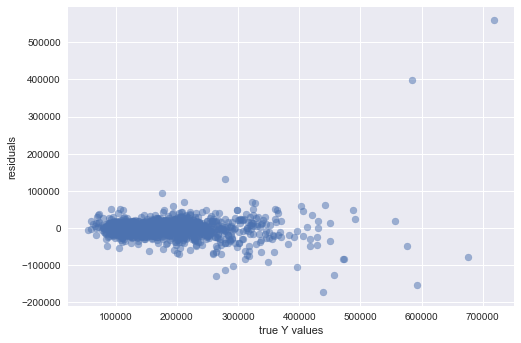

R2 score: 0.86443367348


In [36]:
plt.scatter(np.exp(predicts), np.exp(predicts) - np.exp(Y_log), alpha=0.5)
plt.xlabel('true Y values')
plt.ylabel('residuals')
plt.show()
print('R2 score: %s' % metrics.r2_score(np.exp(predicts), np.exp(Y_log)))

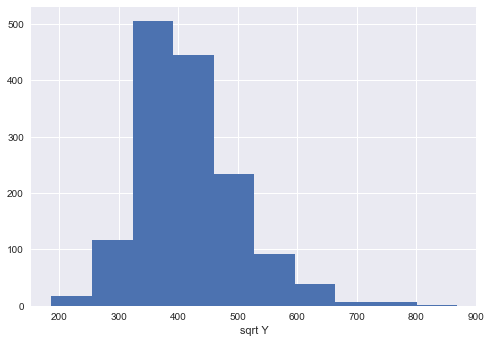

In [37]:
# 取平方根
Y_root = np.sqrt(Y)
plt.hist(Y_root)
plt.xlabel('sqrt Y')
plt.show()

In [38]:
# 对Y的平方根进行套索回归分析
param_grid = {
              'alpha': [0.005, 0.01, 0.05, 1,10,100,200],
             }
lasso = linear_model.Lasso()
lasso_gs = model_selection.GridSearchCV(lasso, param_grid, cv=3, scoring=rmsle)
lasso_gs.fit(X_selected, Y_root)
print(lasso_gs.best_score_)
print(lasso_gs.best_params_)

-0.0679265166585
{'alpha': 0.05}


In [39]:
# 真是得分
lasso_regr = lasso_gs.best_estimator_
predicts = lasso_regr.predict(X_selected)
rmsle_score(Y_root**2, predicts**2)

-0.12117905971395831

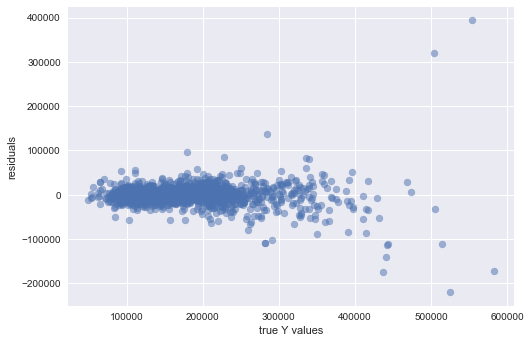

R2 score: 0.877081768375


In [40]:
plt.scatter(predicts**2, predicts**2 - Y_root**2, alpha=0.5)
plt.xlabel('true Y values')
plt.ylabel('residuals')
plt.show()
print('R2 score: %s' % metrics.r2_score(predicts**2, Y_root**2))

#### 3.2 随机森林回归 

In [41]:

param_grid = {
              'n_estimators': [50,100,150,200,250,300],
              'min_samples_leaf': [1,3,5],  
             }
forest = ensemble.RandomForestRegressor()
forest_gs = model_selection.GridSearchCV(forest, param_grid, cv=3, scoring=rmsle)
forest_gs.fit(X_selected, Y)
print(forest_gs.best_score_)
print(forest_gs.best_params_)

-0.147596384899
{'n_estimators': 200, 'min_samples_leaf': 1}


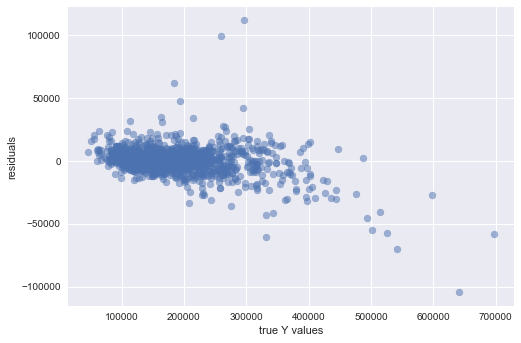

R2 score: 0.980355172627


In [42]:
predicts = forest_gs.best_estimator_.predict(X_selected)
plt.scatter(predicts, predicts-Y, alpha=0.5)
plt.xlabel('true Y values')
plt.ylabel('residuals')
plt.show()
print('R2 score: %s' % metrics.r2_score(predicts, Y))

#### 3.3 XGBoost分析 

In [43]:
import xgboost as xgb
xgb_regressor = xgb.XGBRegressor()

D:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [44]:
param_grid = {
              'n_estimators': [200,300,350,400,450,500],
              'learning_rate': [0.05, 0.1,0.2,0.3,0.4],
             }
xgb_gs = model_selection.GridSearchCV(xgb_regressor, param_grid, cv=3, scoring=rmsle)
xgb_gs.fit(X_selected, Y)
print(xgb_gs.best_score_)
print(xgb_gs.best_params_)

-0.127609688537
{'n_estimators': 350, 'learning_rate': 0.1}


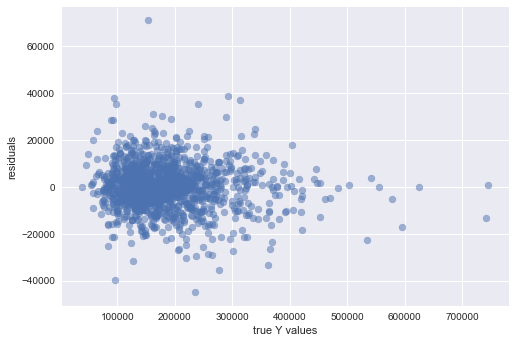

R2 score: 0.985231002373


In [45]:
predicts = xgb_gs.best_estimator_.predict(X_selected)
plt.scatter(predicts, predicts-Y, alpha=0.5)
plt.xlabel('true Y values')
plt.ylabel('residuals')
plt.show()
print('R2 score: %s' % metrics.r2_score(predicts, Y))

## 4. 测试集预测 

In [46]:
X_test_selected = test_data.iloc[:,not_zero_indices[0]]
print(X_test_selected.shape)

(1459, 82)


In [47]:
best_regressor = lasso_gs.best_estimator_ 
best_regressor.fit(X_selected, Y_root)
Y_test = best_regressor.predict(X_test_selected)
Y_test = Y_test**2 

result_df = pd.DataFrame(columns=['Id', 'SalePrice'])
result_df.Id = test_df.Id
result_df.SalePrice = Y_test

result_df.to_csv('MyResult.csv', index=False)

result_df.head()

,Id,SalePrice
0,1461,90795.526187
1,1462,147833.002947
2,1463,144853.007682
3,1464,181135.656593
4,1465,171319.750008


In [48]:
# 岭回归
best_regressor_1 = ridge_gs.best_estimator_
best_regressor_1.fit(X_selected, Y_root)
Y_test_1 = best_regressor.predict(X_test_selected)
Y_test_1 = Y_test_1**2 

result_df_1 = pd.DataFrame(columns=['Id', 'SalePrice'])
result_df_1.Id = test_df.Id
result_df_1.SalePrice = Y_test_1

result_df_1.to_csv('MyResult_Ridge.csv', index=False)

result_df_1.head()

,Id,SalePrice
0,1461,90795.526187
1,1462,147833.002947
2,1463,144853.007682
3,1464,181135.656593
4,1465,171319.750008


In [49]:
# 随机森林回归
best_regressor_2 = ridge_gs.best_estimator_
best_regressor_2.fit(X_selected, Y_root)
Y_test_2 = best_regressor.predict(X_test_selected)
Y_test_2 = Y_test_2**2 

result_df_2 = pd.DataFrame(columns=['Id', 'SalePrice'])
result_df_2.Id = test_df.Id
result_df_2.SalePrice = Y_test_2

result_df_2.to_csv('MyResult_RFR.csv', index=False)

result_df_2.head()

,Id,SalePrice
0,1461,90795.526187
1,1462,147833.002947
2,1463,144853.007682
3,1464,181135.656593
4,1465,171319.750008


In [50]:
# XGBoost回归
best_regressor_3 = ridge_gs.best_estimator_
best_regressor_3.fit(X_selected, Y_root)
Y_test_3 = best_regressor.predict(X_test_selected)
Y_test_3 = Y_test_3**2 

result_df_3 = pd.DataFrame(columns=['Id', 'SalePrice'])
result_df_3.Id = test_df.Id
result_df_3.SalePrice = Y_test_3

result_df_3.to_csv('MyResult_XGBoost.csv', index=False)

result_df_3.head()

,Id,SalePrice
0,1461,90795.526187
1,1462,147833.002947
2,1463,144853.007682
3,1464,181135.656593
4,1465,171319.750008
